---
# cspell:disable
title: Comparing methods for classifying word sense definitions
subtitle: NLP for society class
authors:
    - name: Brenna Hensley
    - name: Philippos Triantafyllou
date: today
date-format: long
lang: en
format:
    pdf:
        pdf-engine: lualatex
        documentclass: scrartcl
        fontsize: 16pt
        papersize: A3
        toccolor: blue
        classoption: 
            - "DIV=12"
            - "parskip=relative"
            - "titlepage=false"
        code-block-border-left: MediumBlue
        code-block-bg: WhiteSmoke
        template-partials:
            - "../pandoc-templates/doc-class.tex"
            - "../pandoc-templates/toc.tex"
            - "../pandoc-templates/before-title.tex"
toc: true
toc-depth: 3
number-sections: true
number-depth: 3
highlight-style: github
fig-cap-location: top
format-links: false
embed-resources: true
# cspell:enable
---

Link to the Colab notebook [here](https://colab.research.google.com/drive/1QrMZJHvuhthrTR6AsP5SHSsaf_hrA2ZZ#scrollTo=FsmiiORgrtuc).

In [3]:
#| echo: false

from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

## Installs & Imports

We use unsloth to install our LLMs. Unlsoth provides a series of advantages, namely:

- 2 times faster training when using a GPU (for this lab, we are running it through Google Colab using a NVIDIA A100 GPU with 40 GB of VRAM);
- Models are memory effoient, which is a good advantage for fine-tuning;
- Models usually have larger context windows, which is usefull in our case since we want to test in-context learning.

In [ ]:
!pip -q install unsloth

In [4]:
from unsloth import FastLanguageModel
import torch

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [108]:
import gzip
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
pd.set_option("display.max_colwidth", 36)

## Data

Link to the dataset.

In [7]:
url = 'http://www.linguist.univ-paris-diderot.fr/~mcandito/divers/super_wiktionary_labeled_data_simplified.noex.25labels.tsv.gz'

Download the data.

In [8]:
def download_and_load_tsv_gz(url):
    filename = url.split('/')[-1]

    if not os.path.exists(filename):
        subprocess.run(['wget', '-q', url], check=True)
    else:
        print(f"File already exists. Skipping download.")

    with gzip.open(filename, 'rt', encoding='utf-8') as f:
        df = pd.read_csv(f, sep='\t')

    return df

In [9]:
try:
    df = download_and_load_tsv_gz(url)
    print("DataFrame loaded successfully.")
except Exception as e:
    print(f"Error loading DataFrame: {e}")

DataFrame loaded successfully.


In [10]:
display(df[['lemma', 'supersense', 'definition']])

,lemma,supersense,definition
0,esquerme,plant,Plante potagère.
1,béruguette,food,Variété d’olive allongée à pulpe...
2,agroécologie,act,Pratique ou mode de production a...
3,webcaméra,artifact,Synonyme de webcam.
4,Reguinois,person,"Habitant de Réguiny, commune fra..."
...,...,...,...
17154,corticothérapie,act,Traitement curatif aux corticoïdes.
17155,combisme,cognition,Laïcisme incarné par Émile Combe...
17156,corapporteur,person,Un des rapporteurs participant à...
17157,antithrombotique,substance,Substance qui empêche la créatio...


Distribution of the supersenses.

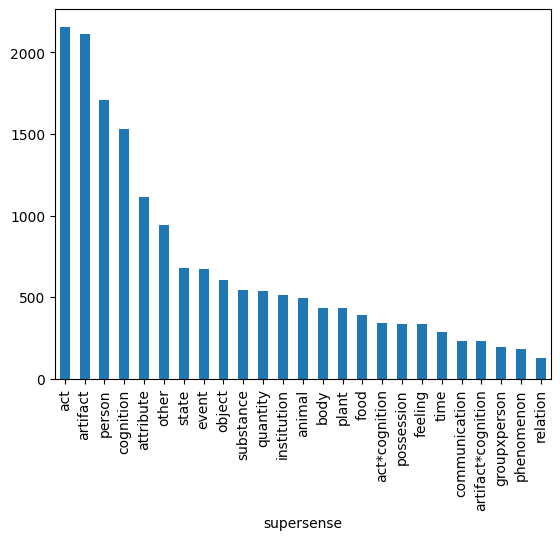

In [11]:
df['supersense'].value_counts().plot(kind='bar')
plt.show()

Hypersenses in English.

In [12]:
print(df['supersense'].unique())

['plant' 'food' 'act' 'artifact' 'person' 'substance' 'cognition' 'other'
 'animal' 'event' 'state' 'time' 'object' 'attribute' 'communication'
 'groupxperson' 'body' 'possession' 'quantity' 'institution' 'phenomenon'
 'feeling' 'act*cognition' 'artifact*cognition' 'relation']


In [13]:
super2hyper = {
    'artifact': 'inanimate',
    'body': 'inanimate',
    'food': 'inanimate',
    'object': 'inanimate',
    'plant': 'inanimate',
    'substance': 'inanimate',
    'act':  'dynamic_situation',
    'event': 'dynamic_situation',
    'phenomenon': 'dynamic_situation',
    'animal': 'animate',
    'person': 'animate',
    'groupxperson': 'animate',
    'cognition': 'information',
    'communication': 'information',
    'quantity': 'quantity',
    'attribute': 'stative_situation',
    'feeling': 'stative_situation',
    'relation': 'stative_situation',
    'state': 'stative_situation',
    'time': 'time',
    'possession': 'possession',
    'institution': 'institution',
    'act*cognition': 'dynamic_situation*information',
    'artifact*cognition': 'inanimate*information',
    'other': 'other',
}

Distribution of the hypersenses.

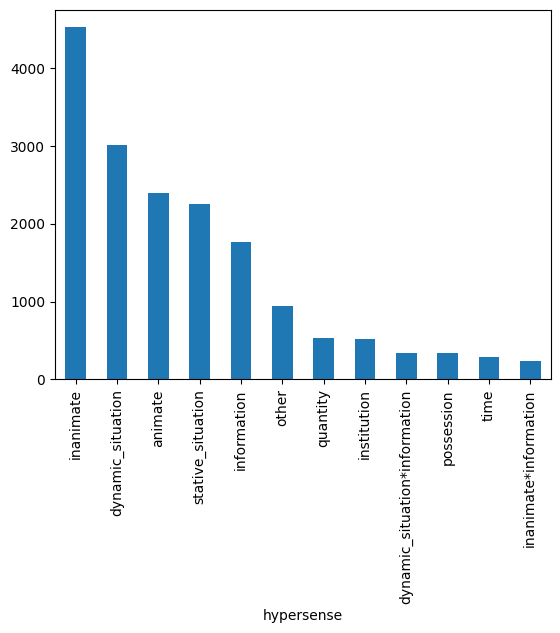

In [15]:
df['hypersense'] = df['supersense'].map(super2hyper)
df['hypersense'].value_counts().plot(kind='bar')
plt.show()

In [16]:
display(df[['lemma', 'hypersense', 'definition']])

,lemma,hypersense,definition
0,esquerme,inanimate,Plante potagère.
1,béruguette,inanimate,Variété d’olive allongée à pulpe...
2,agroécologie,dynamic_situation,Pratique ou mode de production a...
3,webcaméra,inanimate,Synonyme de webcam.
4,Reguinois,animate,"Habitant de Réguiny, commune fra..."
...,...,...,...
17154,corticothérapie,dynamic_situation,Traitement curatif aux corticoïdes.
17155,combisme,information,Laïcisme incarné par Émile Combe...
17156,corapporteur,animate,Un des rapporteurs participant à...
17157,antithrombotique,inanimate,Substance qui empêche la créatio...


Note the distribution in the training set, dev and test sets are quite different.

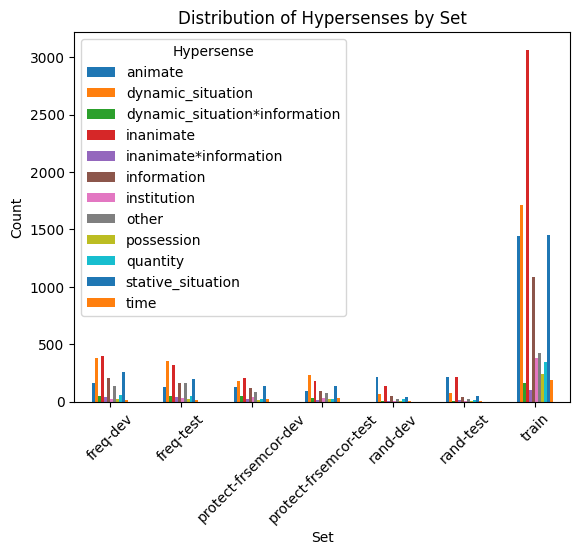

In [17]:
df.groupby('set')['hypersense'].value_counts().unstack().plot(kind='bar')
plt.title('Distribution of Hypersenses by Set')
plt.xlabel('Set')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Hypersense')
plt.show()

Our task is the following: classify word-sense definitions into coarse categories named "hypersenses".

## Few-shot learning

### Load quantized models.

We test with `mistral-7b`. Our reasoning is the following: since we are working with French word-sense definitions and lemmas, we want to see how our results are affected by French only or English only prompts. `mistral-7b` is a good candidate since it is supposed to have both good English and French capabilities. We use the instruct version of the model since we want to perform an in-context learning classification task. Also we use the 4-bit quantized version of the model since it is optimized for `unsloth`.

In [23]:
model_name = ["unsloth/mistral-7b-instruct-v0.3-bnb-4bit"]

The only important hyperparameter is the `MAX_SEQ_LENGTH` that defines the size of the model's context window. As the number of examples provided in the prompts increase, the model needs a a larger context window to process them.

In [20]:
MAX_SEQ_LENGTH = 4096*2
DTYPE = "float16"
LOAD_IN_4BIT = True

We load the models using the `FastLanguageModel.from_pretrained` method and we build a dictionary with the model and tokenizer for `mistral`.

In [24]:
def load_quantized_model(models):
    output = {}
    for model_name in models:
        print(f"Loading {model_name}...")
        model, tokenizer = FastLanguageModel.from_pretrained(
            model_name = model_name,
            max_seq_length = MAX_SEQ_LENGTH,
            dtype = DTYPE,
            load_in_4bit = LOAD_IN_4BIT,
        )
        output[model_name] = {
            "model": model,
            "tokenizer": tokenizer,
        }
    return output

In [25]:
model = load_quantized_model(model_name)

Loading unsloth/mistral-7b-instruct-v0.3-bnb-4bit...
==((====))==  Unsloth 2026.1.2: Fast Mistral patching. Transformers: 4.57.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


### Testing

There are different ways to produce output: streamer mode (each token is printed as it is generated), and "batch" mode (where the output is displayed once generation is complete). We use the batch mode for our experiments.

Furthermore we use a chat template. Although not strictly necessary, it is highly recommended in the `unsloth` documentation, as we can use the specific chat template required by the model and ensure that our prompts are tokenized consistently with the model's architecture. Link to documentation:  https://unsloth.ai/docs/basics/chat-templates.

In [26]:
from transformers import TextStreamer
from unsloth.chat_templates import get_chat_template

In [27]:
mistral_model = model['unsloth/mistral-7b-instruct-v0.3-bnb-4bit']['model']
mistral_tokenizer = model['unsloth/mistral-7b-instruct-v0.3-bnb-4bit']['tokenizer']

We set our model to inference.

In [28]:
FastLanguageModel.for_inference(mistral_model)
text_streamer = TextStreamer(mistral_tokenizer, skip_prompt=True)

The chat template for `mistral` is the following.

In [29]:
tokenizer = get_chat_template(
    mistral_tokenizer,
    chat_template = "mistral",
    mapping = {"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"},
)

### Prompts

Setting up prompting pipeline.

The pipeline is simple:

- One function will extract the relevant information from the training set in the form of a tuple containing the lemma, the word-sense definition, and the hypersense.
- One function will take this information and create a prompt to pass as input to the LLM.

We define the number of examples to be used in the prompt as a parameter.

In [ ]:
def generate_examples(data, n_examples):
    train = data[data['set'] == 'train'] # The examples used in the prompts are drawn from the training set.
    samples = train.sample(n_examples)
    examples = [(x['lemma'], x['definition'], x['hypersense']) for _, x in samples.iterrows()]
    return examples

For example, if we want. 4 in-context examples:

In [33]:
testing = generate_examples(df, 4)
for i in testing:
    print(i)

('essart', 'Taillis qu’on défriche après chaque coupe.', 'inanimate')
('sandale', 'Chaussure qui découvre en partie le dessus du pied.', 'inanimate')
('composante', 'Structure administrative au sein d’un établissement universitaire.', 'institution')
('pollinisation', 'Action de polliniser par le transport du pollen de l’anthère au stigmate de la même fleur ou d’une autre fleur.', 'dynamic_situation')


We define two prompt templates, one for english one for french, the `generate_prompts` function will duplicate this template based on the value provided at `n_examples` (the default is set to 0, equivalent to zero-shot prompting).

In [34]:
prompt_english = """
            Consider the word '{}' with definition: '{}'.
            Please select the most relevant category for the given word definition from following CATEGORIES:
            """ + str(df['hypersense'].unique()) + """.
            CHOICE: {}
        """

prompt_french = """
            Considère le mot '{}' avec la définition : '{}'.
            Sélectionne la catégorie la plus pertinente pour la définition du mot donné parmi les CATÉGORIES suivantes :
            """ + str(df['hypersense'].unique()) + """.
            CHOIX : {}
        """

The `generate_prompts` will generate a different prompt (with different in-context examples) for each input (i.e. the `row` argument, corresponding to one entry from the `rand-dev` set).

In [ ]:
def generate_prompts(data, row, n_examples=0, DO_FRENCH=False, USE_WORD=False, HIDE_ANSWER=True):
    # First we extract from the training set the relevant information to include in the prompt.
    examples = generate_examples(data, n_examples)

    # This option is for LoRA training.
    # Setting the HIDE_ANSWER to True will hide the answer in the prompt. Used for ICL.
    # We want to show the answer when LoRA fine-tuning.
    if HIDE_ANSWER:
        ans = ""
    else:
        ans = row['hypersense']

    # We append the input that the model will use to generate at the end.
    examples.append((row['lemma'], row['definition'], ans))
    examples_list = []

    # Testing between english and french.
    if DO_FRENCH:
        prompt = prompt_french
    else:
        prompt = prompt_english

    # Building the prompt: extract the info, decide if we use the lemma (default: only the w-s definition),
    # format with the prompt template and add to prompt.
    # Also define a final sentence to constrain the model's generation.
    for lemma, definition, sense in examples:
          if USE_WORD:
              ex = prompt.format(lemma, definition, sense)
          else:
              ex = prompt.format("", definition, sense)
          examples_list.append(ex)

          # We also add a final instruction to only answer with the category.
          # We make sure it is in the correct language.
          if DO_FRENCH:
              examples_list.append("Répond seulement avec 'CHOIX : catégorie'.\n")
          else:
              examples_list.append("Only answer with 'CHOICE: category'.\n")

    prompt = "".join(examples_list)
    return prompt

As you can see, for each example we also pass the full list of hypersenses, although one can argue this creates some redundancy and increases the token size of the prompt, it creates consistency and allows the model to understand that the category it has to pick always comes from this specific set. Basically we want our ICL examples to be as close as possible to the actual test example.

To verify that all works well, we use the first example of the dev set.

In [43]:
testing = generate_prompts(df, df[df['set'] == "rand-dev"].iloc[0], 4, True, True, True)
print(testing)


            Considère le mot 'brugnon' avec la définition : 'Espèce de pêche ou de pavie qui a la peau lisse et fine.'.
            Sélectionne la catégorie la plus pertinente pour la définition du mot donné parmi les CATÉGORIES suivantes :
            ['inanimate' 'dynamic_situation' 'animate' 'information' 'other'
 'stative_situation' 'time' 'possession' 'quantity' 'institution'
 'dynamic_situation*information' 'inanimate*information'].
            CHOIX : inanimate
        Répond seulement avec 'CHOIX : catégorie'.

            Considère le mot 'lamantin' avec la définition : 'Genre de mammifère aquatique herbivore voisin du dugong du genre Trichechus.'.
            Sélectionne la catégorie la plus pertinente pour la définition du mot donné parmi les CATÉGORIES suivantes :
            ['inanimate' 'dynamic_situation' 'animate' 'information' 'other'
 'stative_situation' 'time' 'possession' 'quantity' 'institution'
 'dynamic_situation*information' 'inanimate*information'].
          

### Building the evaluation pipeline

We define a function to create HF Dataset object: we simply select the set we want to use, create a mapping of labels2ids (for evaluation, we use HF's evaluator pipeline, link: https://huggingface.co/docs/evaluate/custom_evaluator, so we define a custom class following the example in the link) as it is needed by our evaluator, and apply the `generate_prompts` function to all the rows of the test/dev dataset.

The initial goal of using the HF `evaluator` was that it provides a simple way to compute accuracy and other metrics. However, we found out that it behaves very badly when doing multi-class classification, because it internally calls `sklearn.metrics`, and hard codes that we are doing binary classification...

We keep the code for completeness, but in the evaluation step for ICL and LoRA, we manually compute accuracy and perform error analysis.

In [ ]:
from datasets import Dataset

def build_eval_dataset(data, set2use, n_examples=4, DO_FRENCH=False, USE_WORD=False):
    dev = data[data['set'] == set2use]

    # It is redundant to create the mapping every time, but for ease of access we keep it here.
    mapping = {v: k for k, v in enumerate(data['hypersense'].unique())}

    dataset_dict = {
        "prompt": dev.apply(lambda row: generate_prompts(data, row, n_examples, DO_FRENCH, USE_WORD), axis=1).tolist(),
        "gold": [mapping[x] for x in dev["hypersense"].tolist()],
    }

    dataset = Dataset.from_dict(dataset_dict)

    return dataset, mapping

In [53]:
few_shot_dev, few_shot_dev_mapping = build_eval_dataset(df, "rand-dev", 4)
print(few_shot_dev)

Dataset({
    features: ['prompt', 'gold'],
    num_rows: 570
})


In [48]:
!pip -q install evaluate

The evaluation pipeline is the following:

- Set the model for inference;
- Set the tokenizer to use the correct template;
- Format the prompt;
- Generate (low temperature, low max chars as model has to output a single category);
- Get the output and decode.

In [ ]:
from tqdm import tqdm
import evaluate

# Our metric is accuracy.
# We tried using f1 but unfortunately HF evaluator does not behave well with multi-class classification.
metric = evaluate.load("accuracy")

class OurPipeline:
    def __init__(self, model, tokenizer, mapping):
        # Required by the evaluator.
        self.task = "text-classification"

        # All the initialization seps required to use the model.
        self.mapping = mapping
        self.model = model

        # Eval mode.
        FastLanguageModel.for_inference(self.model)
        self.model.eval()

        # Formatting the tokenizer with the model's chat template.
        self.tokenizer = get_chat_template(
            tokenizer,
            chat_template="mistral",
            mapping={
                "role": "from",
                "content": "value",
                "user": "human",
                "assistant": "gpt",
            },
        )

    def __call__(self, data, **kwargs):
        # Store the outputs for evaluation.
        outputs= []

        # Loop over each example.
        for example in tqdm(data, desc="Running inference"):
            # Following the generation code defined above.
            # IMPORTANT: The evaluator internally changes the variable names!
            # example['prompt'] becomes example['text'].
            messages = [{"from": "human", "value": example['text']}]
            inputs = self.tokenizer.apply_chat_template(
                messages,
                tokenize=True,
                add_generation_prompt=True,
                return_tensors="pt",
            ).to(self.model.device)

            with torch.no_grad():
                output_ids = self.model.generate(
                    input_ids=inputs,
                    max_new_tokens=64,
                    temperature=0.01, # Low temperature for more deterministic outputs
                    use_cache=True,
                )

            generated_ids = output_ids[0][inputs.shape[-1]:]
            out = self.tokenizer.decode(generated_ids, skip_special_tokens=True)

            # Manually map the output to the correct ids, if the model generates a class that is not in the list, return 100.
            # Simple (and inelegant...) replace call to only get the class.
            outputs.append(self.mapping.setdefault(
                out.replace("CHOICE: ", "").replace("CHOIX : ", "").strip(), 100
            ))

        # Format required by the evaluator.
        return [{"label": out} for out in outputs]

In [89]:
few_shot_pipe = OurPipeline(mistral_model, mistral_tokenizer, few_shot_dev_mapping)

Wrapper for `evaluator` pipeline. We pass in the model, and the data we are evaluating on. It automatically runs inference and computes accuracy.

In [93]:
from evaluate import evaluator

def eval(model, data, input_name="prompt", label_name="gold"):
    text_classifier = evaluator("text-classification")
    results = text_classifier.compute(
        model_or_pipeline=model,
        data=data,
        metric="accuracy",
        input_column=input_name,
        label_column=label_name
    )

    return results

Small function for grid search. Computing the grid search over the entire dev set is time consuming and costly, so we suggest to run it over a small subset of the dev set (e.g. 50 examples per hyperparameter setting).

In [90]:
def random_select(dataset, n, seed=42):
    return dataset.shuffle(seed=seed).select(range(n))

### Grid Search

The grid search tests the following hyperparameters:

- Number of in-context examples: 0,2,4,8,16,32;
- French prompt or English prompt;
- Include lemma in the prompt or not.

In [94]:
def grid_search():
    out_results = {True:{True:{},False:{}},False:{True:{},False:{}}}
    for n_examples in [0,2,4,8,16,32]:
        for DO_FRENCH in [True, False]:
            for USE_WORD in [True, False]:
                # Again, since the mapping is the same, we can ignore it here.
                few_shot_dev, _ = build_eval_dataset(df, "rand-dev", n_examples, DO_FRENCH, USE_WORD)
                print("Num. of examples =", n_examples, "French prompt =", str(DO_FRENCH), "Include lemma =", str(USE_WORD))
                
                # Using a random sample of 50 examples for faster grid search.
                random_sample = random_select(few_shot_dev, 50) 
                
                # We use the few_shot_pipe defined above.
                results = eval(few_shot_pipe, random_sample)
                out_results[DO_FRENCH][USE_WORD][n_examples]=results['accuracy']
                print("Accuracy:", results['accuracy'])

    return out_results

In [ ]:
out = grid_search()

Num. of examples = 0 French prompt = True Include lemma = True


Running inference: 100%|██████████| 50/50 [00:19<00:00,  2.53it/s]


Accuracy: 0.4
Num. of examples = 0 French prompt = True Include lemma = False


Running inference: 100%|██████████| 50/50 [00:19<00:00,  2.57it/s]


Accuracy: 0.36
Num. of examples = 0 French prompt = False Include lemma = True


Running inference: 100%|██████████| 50/50 [00:21<00:00,  2.27it/s]


Accuracy: 0.1
Num. of examples = 0 French prompt = False Include lemma = False


Running inference: 100%|██████████| 50/50 [00:23<00:00,  2.12it/s]


Accuracy: 0.04
Num. of examples = 2 French prompt = True Include lemma = True


Running inference: 100%|██████████| 50/50 [00:25<00:00,  1.99it/s]


Accuracy: 0.42
Num. of examples = 2 French prompt = True Include lemma = False


Running inference: 100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


Accuracy: 0.44
Num. of examples = 2 French prompt = False Include lemma = True


Running inference: 100%|██████████| 50/50 [00:41<00:00,  1.22it/s]


Accuracy: 0.2
Num. of examples = 2 French prompt = False Include lemma = False


Running inference: 100%|██████████| 50/50 [00:36<00:00,  1.37it/s]


Accuracy: 0.28
Num. of examples = 4 French prompt = True Include lemma = True


Running inference: 100%|██████████| 50/50 [00:34<00:00,  1.45it/s]


Accuracy: 0.32
Num. of examples = 4 French prompt = True Include lemma = False


Running inference: 100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


Accuracy: 0.36
Num. of examples = 4 French prompt = False Include lemma = True


Running inference: 100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


Accuracy: 0.22
Num. of examples = 4 French prompt = False Include lemma = False


Running inference: 100%|██████████| 50/50 [01:15<00:00,  1.50s/it]


Accuracy: 0.18
Num. of examples = 8 French prompt = True Include lemma = True


Running inference: 100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Accuracy: 0.24
Num. of examples = 8 French prompt = True Include lemma = False


Running inference: 100%|██████████| 50/50 [00:51<00:00,  1.03s/it]


Accuracy: 0.18
Num. of examples = 8 French prompt = False Include lemma = True


Running inference: 100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


Accuracy: 0.14
Num. of examples = 8 French prompt = False Include lemma = False


Running inference: 100%|██████████| 50/50 [01:16<00:00,  1.52s/it]


Accuracy: 0.28
Num. of examples = 16 French prompt = True Include lemma = True


Running inference: 100%|██████████| 50/50 [00:25<00:00,  1.93it/s]


Accuracy: 0.48
Num. of examples = 16 French prompt = True Include lemma = False


Running inference: 100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


Accuracy: 0.36
Num. of examples = 16 French prompt = False Include lemma = True


Running inference: 100%|██████████| 50/50 [01:25<00:00,  1.71s/it]


Accuracy: 0.28
Num. of examples = 16 French prompt = False Include lemma = False


Running inference: 100%|██████████| 50/50 [01:19<00:00,  1.58s/it]


Accuracy: 0.22
Num. of examples = 32 French prompt = True Include lemma = True


Running inference: 100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


Accuracy: 0.44
Num. of examples = 32 French prompt = True Include lemma = False


Running inference: 100%|██████████| 50/50 [00:38<00:00,  1.29it/s]


Accuracy: 0.54
Num. of examples = 32 French prompt = False Include lemma = True


Running inference: 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


Accuracy: 0.32
Num. of examples = 32 French prompt = False Include lemma = False


Running inference: 100%|██████████| 50/50 [01:40<00:00,  2.00s/it]

Accuracy: 0.18


In [96]:
# Visualizing the results of the grid search.
# We make it into a pandas DataFrame and then output as markdown.
from IPython.core.display import Markdown

grid_search_results = []
for DO_FRENCH in out:
    for USE_WORD in out[DO_FRENCH]:
        for n_examples in out[DO_FRENCH][USE_WORD]:
            accuracy = out[DO_FRENCH][USE_WORD][n_examples]
            grid_search_results.append({
                "DO_FRENCH": DO_FRENCH,
                "USE_WORD": USE_WORD,
                "N_EXAMPLES": n_examples,
                "ACCURACY": accuracy
            })
grid_search_df = pd.DataFrame(grid_search_results)
Markdown(grid_search_df.to_markdown(index=False))

| DO_FRENCH   | USE_WORD   |   N_EXAMPLES |   ACCURACY |
|:------------|:-----------|-------------:|-----------:|
| True        | True       |            0 |       0.4  |
| True        | True       |            2 |       0.42 |
| True        | True       |            4 |       0.32 |
| True        | True       |            8 |       0.24 |
| True        | True       |           16 |       0.48 |
| True        | True       |           32 |       0.44 |
| True        | False      |            0 |       0.36 |
| True        | False      |            2 |       0.44 |
| True        | False      |            4 |       0.36 |
| True        | False      |            8 |       0.18 |
| True        | False      |           16 |       0.36 |
| True        | False      |           32 |       0.54 |
| False       | True       |            0 |       0.1  |
| False       | True       |            2 |       0.2  |
| False       | True       |            4 |       0.22 |
| False       | True       |            8 |       0.14 |
| False       | True       |           16 |       0.28 |
| False       | True       |           32 |       0.32 |
| False       | False      |            0 |       0.04 |
| False       | False      |            2 |       0.28 |
| False       | False      |            4 |       0.18 |
| False       | False      |            8 |       0.28 |
| False       | False      |           16 |       0.22 |
| False       | False      |           32 |       0.18 |

It appears that having a french prompt and not including the lemma consistently produces better results as number of examples increases. Strangely, we do not understand why not including the lemma confuse the model. There is no consistent improvement when increasing the number of examples, and we believe that this is due to the fact that at each hyperparameter specification, we randomly sample examples, therefore introducing uncontrolled variance in the results.

### Evaluation on test sets

Small function to compute accuracy.

In [98]:
def compute_accuracy(output, data):
    predicted_labels = [item['label'] for item in output]
    true_labels = data["gold"]
    return sum(np.array(predicted_labels) == np.array(true_labels)) / len(true_labels)

We evaluate with the hyperparameters that have the highest accuracy during the grid search. First on the random test set, and then on the frequency-based test set.

In [ ]:
rand_test_set_ICL, _ = build_eval_dataset(df, "rand-test", 32, True, False)
output_rand_test = few_shot_pipe(rand_test_set_ICL.rename_column("prompt", "text"))

In [102]:
rand_test_accuracy = compute_accuracy(output_rand_test, rand_test_set_ICL)
print("Random Test Set Accuracy:", rand_test_accuracy)

Random Test Set Accuracy: 0.6253687315634219


In [167]:
freq_test_set_ICL, _ = build_eval_dataset(df, "freq-test", 32, True, False)
output_freq_test = few_shot_pipe(freq_test_set_ICL.rename_column("prompt", "text"))

Running inference: 100%|██████████| 1521/1521 [19:44<00:00,  1.28it/s]


In [168]:
import pickle
with open("freq_test_output.pkl", "wb") as f:
    pickle.dump(output_freq_test, f)

In [169]:
freq_test_accuracy = compute_accuracy(output_freq_test, freq_test_set_ICL)
print("Frequent Test Set Accuracy:", freq_test_accuracy)

Frequent Test Set Accuracy: 0.46614069690992765


For our error analysis, we plot the confusion matrix between the true labels and the predicted labels.

In [134]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def error_analysis(output, data):
    mapping = {v: k for k, v in enumerate(df['hypersense'].unique())}
    mapping['Hallucination'] = 100
    all_labels = sorted(set(mapping.values()))
    true_labels = data["gold"]
    predicted_labels = [item['label'] for item in output]
    c = confusion_matrix(true_labels, predicted_labels, labels=all_labels)
    display_labels_ordered = [label for label, _ in sorted(mapping.items(), key=lambda item: item[1])]
    ConfusionMatrixDisplay(c, display_labels=display_labels_ordered).plot()
    plt.xticks(rotation=90)
    plt.rcParams["figure.figsize"] = (8,4)
    plt.show()

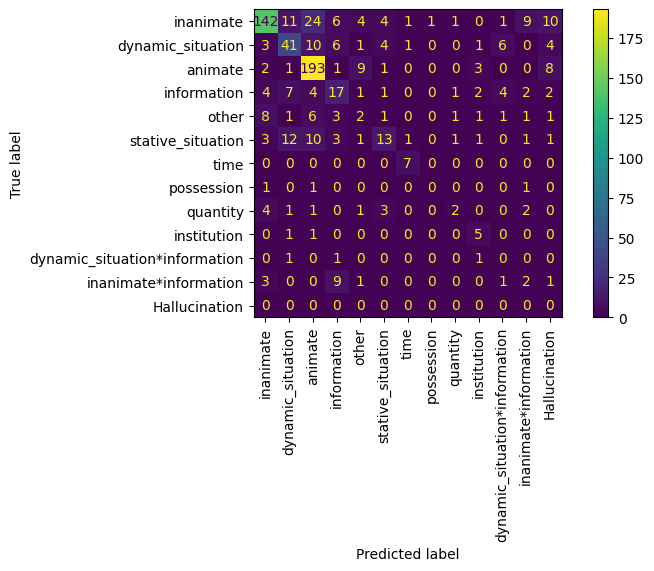

In [135]:
error_analysis(output_rand_test, rand_test_set_ICL)

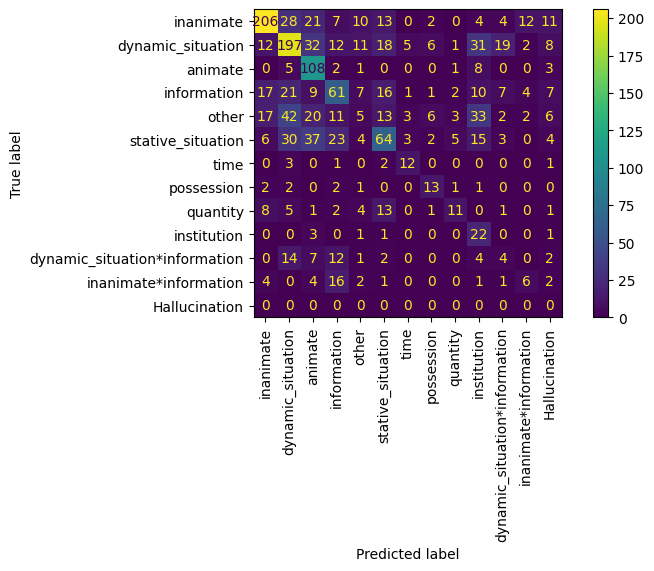

In [170]:
error_analysis(output_freq_test, freq_test_set_ICL)

The less represented classes tend to be not predicted because the model either hallucinates or has not seen them during the in-context examples.

Compound classes are particularly hard to predict, they get misclassified as one of their components.

Some rare classes are very well classified, probably because they are very distinct from the other classes (e.g. "institution").

Overall, accuracies are not very high, and most often than not, the model is guessing between the most frequent classes (or simply guessing). This is especially true for the frequency-based test set, as we cannot distinguish any clear pattern other than the fact that the most frequent classes are predicted more often.

## LoRA Fine-Tuning

For the following code, we mostly followed the instructions by the `unsloth` tutorial lab: https://colab.research.google.com/drive/1_yNCks4BTD5zOnjozppphh5GzMFaMKq_?usp=sharing.

### Set up train data for fine tuning

We set up a function similar to `build_eval_dataset`.

In [147]:
# Must add EOS_TOKEN
EOS_TOKEN = mistral_tokenizer.eos_token

def build_train_set(data, DO_FRENCH=False, USE_WORD=False):
    train = data[data['set'] == 'train']
    mapping = {v: k for k, v in enumerate(data['hypersense'].unique())}

    dataset_dict = {
        "prompt": train.apply(
            lambda row: generate_prompts(data, row, 0, DO_FRENCH, USE_WORD, False) + EOS_TOKEN, axis=1
        ).tolist(),
        "gold": [mapping[x] for x in train["hypersense"].tolist()],
    }

    dataset = Dataset.from_dict(dataset_dict)

    return dataset, mapping

In [148]:
train_set, train_mapping = build_train_set(df, True, False) # True for french prompt, False to not include lemma

### Load new model

In [149]:
lora_model = load_quantized_model(model_name)

Loading unsloth/mistral-7b-instruct-v0.3-bnb-4bit...
==((====))==  Unsloth 2026.1.2: Fast Mistral patching. Transformers: 4.57.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


The `get_peft_model` adds LoRA adapters to the model for efficient fine-tuning. Below we give a short description of each of the arguments:

- `model_lora`: the base model to add LoRA adapters to;
- `r`: the rank of the LoRA decomposition, which controls how many parameters are added (higher = more parameters but better approximation);
- `target_modules`: which layers of the transformer to apply LoRA to (q/k/v are attention projections, o is attention output, gate/up/down are MLP layers);
- `lora_alpha`: scaling factor for LoRA updates, set equal to r;
- `lora_dropout`: dropout probability for LoRA layers, set to 0 for better Unsloth optimization;
- `bias`: whether to train bias terms, "none" means no bias training, optimized in Unsloth;
- `use_gradient_checkpointing`: whether to use gradient checkpointing to save memory at the cost of speed, "unsloth" uses Unsloth's optimized version;
- `random_state`: seed for reproducibility of random initialization;
- `use_rslora`: whether to use rank-stabilized LoRA, a variant that can improve training stability;
- `loftq_config`: configuration for LoftQ initialization method, None means standard initialization.

In [150]:
tokenizer_lora = model['unsloth/mistral-7b-instruct-v0.3-bnb-4bit']['tokenizer']

model_lora = FastLanguageModel.get_peft_model(
    lora_model['unsloth/mistral-7b-instruct-v0.3-bnb-4bit']['model'],
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

Unsloth 2026.1.2 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


### Training

In [151]:
from trl.trainer.sft_trainer import SFTTrainer
from transformers import TrainingArguments

In [152]:
# Required for SFTTrainer
def formatting_prompts_func(examples):
    return list(examples["prompt"])

In [153]:
# Code taken from the unsloth documentation colab.
trainer = SFTTrainer(
    model = model_lora,
    tokenizer = tokenizer_lora,
    train_dataset = train_set, # Use the converted dataset.
    dataset_text_field = "prompt",
    max_seq_length = MAX_SEQ_LENGTH,
    dataset_num_proc = 2,
    packing = False,
    formatting_func = formatting_prompts_func,

    # Arguments follow the tutorial defaults (changed number of epochs = 30).
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30, # Set num_train_epochs = 1 for full training runs.
        learning_rate = 2e-4,
        fp16 = True,
        bf16 = False, # This is the only value we tweaked, we use fp16.
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",
    )
)

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/10604 [00:00<?, ? examples/s]

In [154]:
losses = trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 10,604 | Num Epochs = 1 | Total steps = 30
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 7,289,966,592 (0.58% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.663400
2,2.615000
3,2.610100
4,2.368600
5,1.946300
6,1.565000
7,1.162000
8,1.098900
9,0.849600
10,0.649500


### Evaluation on the test sets

We initialize an evaluation pipeline, we use the training mappings since the label2id mapping is the same across all datasets.

In [155]:
lora_pipe = OurPipeline(model_lora, tokenizer_lora, train_mapping)

In [157]:
rand_test_lora, _ = build_eval_dataset(df, "rand-test", 0, True, False)
output_rand_test_lora = lora_pipe(rand_test_lora.rename_column("prompt", "text"))

Running inference: 100%|██████████| 678/678 [06:49<00:00,  1.66it/s]


In [158]:
rand_test_lora_accuracy = compute_accuracy(output_rand_test_lora, rand_test_lora)
print("Random Test Set Accuracy after LoRA:", rand_test_lora_accuracy)

Random Test Set Accuracy after LoRA: 0.700589970501475


LoRA fine-tuning appears to greatly improve the performance. Considering that ICL evaluation on the random test set rendered an accuracy of around 60%, LoRA achieved a 10 percentage point increase over the 32 example prompt and 20% increase from the zero-shot ICL setting (all accuracies obtained with French prompts and without lemmas).

In [162]:
freq_test_lora, _ = build_eval_dataset(df, "freq-test", 0, True, False)
output_freq_test_lora = lora_pipe(freq_test_lora.rename_column("prompt", "text"))

Running inference: 100%|██████████| 1521/1521 [16:57<00:00,  1.49it/s]


In [166]:
freq_test_lora_accuracy = compute_accuracy(output_freq_test_lora, freq_test_lora)
print("Frequent Test Set Accuracy after LoRA:", freq_test_lora_accuracy)

Frequent Test Set Accuracy after LoRA: 0.514792899408284


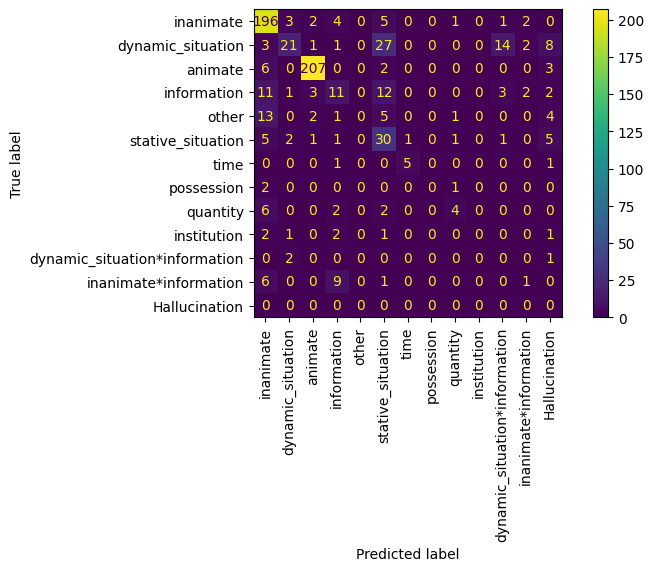

In [161]:
error_analysis(output_rand_test_lora, rand_test_lora)

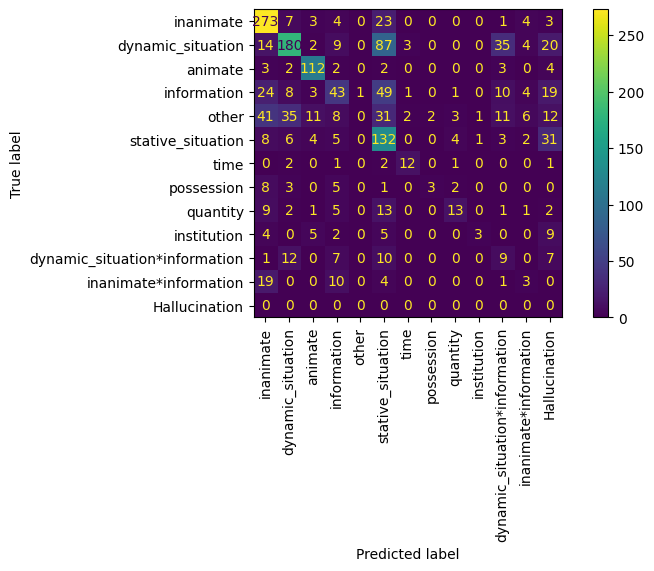

In [165]:
error_analysis(output_freq_test_lora, freq_test_lora)

Looking at the confusion matrices as well as the class distribution in the different sets, we notice that random test is dominated by "animate" and "inanimate". These classes are also well attested in the training set, therefore, they carry the accuracy of the model on the random test set. On the other hand, frequency-based test set has a more balanced distribution of classes, therefore "animate" and "inanimate" do not dominate the accuracy as much.

Overall, the classes that are frequent in the training set tend to be predicted correctly mor often that the less frequent classes, especially the compound ones. We notice a slight trend for the combined classes to be misclassified to one of the components or a similar class (i.e. "dynamic_situation" getting classified as "stative_situation").